In [39]:
import aif360
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.preprocessing import Reweighing

In [40]:
df = pd.read_csv('data/dataframe_final.csv')
protected_attributes = ['GENDER', 'LANGUAGE', 'INSURANCE', 'RELIGION', 'ETHNICITY', 'AGE']
protected_attribute = 'RELIGION'
df

,SUBJECT_ID,Y_PRED,Y_TRUE,GENDER,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,AGE
0,10011,1,1,0,1,1,1,0,1
1,10026,0,0,0,1,1,0,1,0
2,10030,0,0,1,1,1,1,1,0
3,10042,0,0,1,1,1,1,1,0
4,10094,0,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...
3231,9970,0,0,1,1,1,1,1,1
3232,9977,0,0,1,1,1,1,1,0
3233,99863,0,0,1,0,1,1,1,1
3234,99883,0,0,1,1,1,1,1,0


In [41]:
def createBinaryDataset(df, ytrue_df, protected_attribute):
    ytrue_df.rename(columns={0: 'Y_TRUE'}, inplace=True)
    attribute_df = df[protected_attribute].to_frame()
    attribute_df.rename(columns={0: protected_attribute}, inplace=True)
    attribute_df = pd.concat([attribute_df, ytrue_df], axis=1)

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=attribute_df,
        label_names=['Y_TRUE'],
        protected_attribute_names=[protected_attribute]
    )

    return dataset

def runMetrics(dataset, dataset_pred, unprivileged_groups, privileged_groups):
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    print("Accuracy: ", classified_metric.accuracy())
    print("Error Rate Difference: ", classified_metric.difference(classified_metric.error_rate))
    print("False Discovery Rate Difference: ", classified_metric.difference(classified_metric.false_discovery_rate))
    print("False Omission Rate Difference: ", classified_metric.difference(classified_metric.false_omission_rate))
    print("Differential Fairness Bias Amplification: ", classified_metric.differential_fairness_bias_amplification())
    print("Disparate Impact", classified_metric.disparate_impact())
    print("---------------------------------------------")

    return (classified_metric.difference(classified_metric.error_rate), classified_metric.difference(classified_metric.false_omission_rate))
    
# prepare the dataset in the format that aif360 requires
dataset = createBinaryDataset(df, df['Y_TRUE'].to_frame(), protected_attribute)
df_pred = df['Y_PRED'].to_frame()
df_pred.rename(columns={'Y_PRED': 'Y_TRUE'}, inplace=True)
dataset_pred = createBinaryDataset(df, df_pred, protected_attribute)

# creates an object that computes metrics for binary classification
index = dataset_pred.protected_attribute_names.index(protected_attribute)
privileged_groups = [{protected_attribute: dataset_pred.privileged_protected_attributes[index][0]}]
unprivileged_groups = [{protected_attribute: dataset_pred.unprivileged_protected_attributes[index][0]}]

# postprocessing bias mitigation using calibrated equal odds and transforming the predictions
rw = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
rw = rw.fit(dataset)
dataset_pred_transf = rw.transform(dataset_pred)

weights_df = df.copy()

weights_df.insert(2, "WEIGHT", dataset_pred_transf.convert_to_dataframe()[1]['instance_weights'])
weights_df = weights_df[['SUBJECT_ID', 'WEIGHT']]
# weights_df.to_csv('./data/weights.csv', index=False)
print(weights_df)

      SUBJECT_ID    WEIGHT
0          10011  1.011741
1          10026  1.008448
2          10030  0.998486
3          10042  0.998486
4          10094  0.998486
...          ...       ...
3231        9970  0.998486
3232        9977  0.998486
3233       99863  0.998486
3234       99883  0.998486
3235       99899  1.011741

[3236 rows x 2 columns]


In [42]:
df_mitigated = pd.read_csv('data/dataframe_mitigated_religion_final.csv')

df_pred = df_mitigated['Y_PRED'].to_frame()
df_pred.rename(columns={'Y_PRED': 'Y_TRUE'}, inplace=True)
dataset_pred_mitig = createBinaryDataset(df_mitigated, df_pred, protected_attribute)

metrics_df = pd.DataFrame(columns=['Value','Attribute','Metric'])

print("=============================================")
print(protected_attribute)
print("=============================================")
print("Before bias mitigation: ")

metrics = runMetrics(dataset, dataset_pred, unprivileged_groups, privileged_groups)
metrics_df = metrics_df.append({'Value':metrics[0], 'Attribute': 'Before', 'Metric': 'Error'}, ignore_index=True)
metrics_df = metrics_df.append({'Value':metrics[1], 'Attribute': 'Before', 'Metric': 'False Omission'}, ignore_index=True)

print("After bias mitigation: ")

metrics = runMetrics(dataset, dataset_pred_mitig, unprivileged_groups, privileged_groups)
metrics_df = metrics_df.append({'Value':metrics[0], 'Attribute': 'After', 'Metric': 'Error'}, ignore_index=True)
metrics_df = metrics_df.append({'Value':metrics[1], 'Attribute': 'After', 'Metric': 'False Omission'}, ignore_index=True)

RELIGION
Before bias mitigation: 
Accuracy:  0.8995673671199012
Error Rate Difference:  0.021871320932422833
False Discovery Rate Difference:  0.09905189620758481
False Omission Rate Difference:  0.021632731033483316
Differential Fairness Bias Amplification:  0.13609627856262874
Disparate Impact 0.7938960788101216
---------------------------------------------
After bias mitigation: 
Accuracy:  0.8949320148331273
Error Rate Difference:  0.014015775841770717
False Discovery Rate Difference:  0.030293106271491732
False Omission Rate Difference:  0.016369625241544353
Differential Fairness Bias Amplification:  0.049537083357777956
Disparate Impact 0.8692893401015228
---------------------------------------------


In [45]:
print("Dataset F1 Score", f1_score(df['Y_TRUE'], df['Y_PRED'], average='macro'))
print("Dataset Preprocessing F1 Score", f1_score(df_mitigated['Y_TRUE'], df_mitigated['Y_PRED'], average='macro'))

Dataset F1 Score 0.6848796463173287
Dataset Preprocessing F1 Score 0.6886471557047208


/home/vasilis/anaconda3/envs/mimic3/lib/python3.7/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


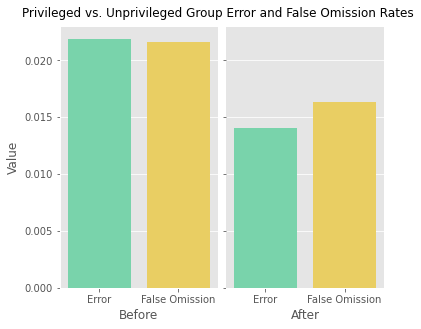

In [44]:
plt.style.use('ggplot')

g = sns.catplot(data=metrics_df, x="Metric", col="Attribute", y="Value", kind='bar', sharex=False, palette=['#6ae2ac', '#ffdb4d'], aspect=.5)
g.set_titles("{col_name}")
g.set_ylabels('Value')
plt.suptitle("Privileged vs. Unprivileged Group Error and False Omission Rates")
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title())
    ax.set_title('')
plt.subplots_adjust(wspace=0.05, bottom=0.2, left=0.06)
plt.savefig('images/preprocessing.png', bbox_inches='tight')
plt.show()